In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

from IPython.core.pylabtools import figsize


In [2]:
import sys

sys.path.append('../src')

from data_preprocessing import df, X_scaled,  y

X_scaled.head()



       summertime          temp           dew      humidity        precip  \
count  1600.00000  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean      0.64375 -6.883383e-17 -8.881784e-18 -5.329071e-17 -1.332268e-17   
std       0.47904  1.000313e+00  1.000313e+00  1.000313e+00  1.000313e+00   
min       0.00000 -2.624768e+00 -2.608989e+00 -2.520668e+00 -1.326092e-01   
25%       0.00000 -8.108835e-01 -8.530852e-01 -8.432055e-01 -1.326092e-01   
50%       1.00000  3.127737e-02  5.479718e-02  6.538701e-02 -1.326092e-01   
75%       1.00000  8.626413e-01  9.028192e-01  8.402859e-01 -1.326092e-01   
max       1.00000  2.201461e+00  1.651074e+00  1.885456e+00  2.797851e+01   

          windspeed    cloudcover    visibility     month_sin     month_cos  \
count  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean   5.107026e-17  1.332268e-16  7.904788e-16  2.553513e-17  3.108624e-17   
std    1.000313e+00  1.000313e+00  1.000313e+00  1.000313e+00  1.0003

,summertime,temp,dew,humidity,precip,windspeed,cloudcover,visibility,month_sin,month_cos,hour_of_day_sin,hour_of_day_cos,day_0,day_1,day_2,day_3,day_4,day_5,day_6,snow_or_not
0,0,-2.419627,-2.269781,-0.537283,-0.132609,0.414935,-0.999503,0.282338,0.678434,1.227255,1.371739,0.367380,False,False,False,False,False,True,False,0
1,0,-1.782607,-2.050293,-1.203654,-0.132609,1.395045,0.652979,0.282338,0.678434,1.227255,-1.013450,0.996355,False,False,False,False,True,False,False,0
2,1,1.262128,1.401656,0.496090,-0.132609,-1.687144,0.512472,0.282338,-1.259495,-0.699517,-1.013450,0.996355,False,False,False,True,False,False,False,0
3,0,-1.307542,-1.172340,-0.219564,-0.132609,0.788924,-1.964724,0.282338,0.678434,1.227255,0.363639,1.359495,False,False,False,False,False,False,True,0
4,0,-0.379006,-1.910618,-2.370721,-0.132609,-0.333044,-0.602419,0.282338,1.387764,0.005730,-1.382440,-0.358899,True,False,False,False,False,False,False,0


In [ ]:
#pd.plotting.scatter_matrix(X_scaled.iloc[:, 1:21], figsize=(10,10))
#plt.show()

kNN

*Cross validation*
rekommenderas för kNN

In [3]:
X_scaled[:10]

,summertime,temp,dew,humidity,precip,windspeed,cloudcover,visibility,month_sin,month_cos,hour_of_day_sin,hour_of_day_cos,day_0,day_1,day_2,day_3,day_4,day_5,day_6,snow_or_not
0,0,-2.419627,-2.269781,-0.537283,-0.132609,0.414935,-0.999503,0.282338,0.678434,1.227255,1.371739,0.367380,False,False,False,False,False,True,False,0
1,0,-1.782607,-2.050293,-1.203654,-0.132609,1.395045,0.652979,0.282338,0.678434,1.227255,-1.013450,0.996355,False,False,False,False,True,False,False,0
2,1,1.262128,1.401656,0.496090,-0.132609,-1.687144,0.512472,0.282338,-1.259495,-0.699517,-1.013450,0.996355,False,False,False,True,False,False,False,0
3,0,-1.307542,-1.172340,-0.219564,-0.132609,0.788924,-1.964724,0.282338,0.678434,1.227255,0.363639,1.359495,False,False,False,False,False,False,True,0
4,0,-0.379006,-1.910618,-2.370721,-0.132609,-0.333044,-0.602419,0.282338,1.387764,0.005730,-1.382440,-0.358899,True,False,False,False,False,False,False,0
5,1,1.283722,0.503750,-1.203130,-0.132609,0.066738,0.518581,0.282338,1.387764,0.005730,-1.382440,-0.358899,False,False,False,True,False,False,False,0
6,1,1.694005,1.651074,0.198294,-0.132609,0.930783,-0.428313,0.282338,-0.740228,-1.215794,-1.240015,0.705772,False,False,False,False,True,False,False,0
7,0,-1.113198,-0.942876,-0.076957,-0.132609,1.085537,1.089771,0.282338,-0.030897,1.416225,-0.005351,1.407303,False,True,False,False,False,False,False,0
8,0,0.150044,0.603517,1.029292,-0.132609,0.647066,0.750722,0.282338,-0.740228,1.227255,-1.431019,0.004240,True,False,False,False,False,False,False,0
9,0,-2.128109,-1.990432,-0.460737,-0.132609,-0.088017,-1.219427,0.282338,0.678434,1.227255,1.371739,-0.358899,False,False,False,False,False,True,False,0


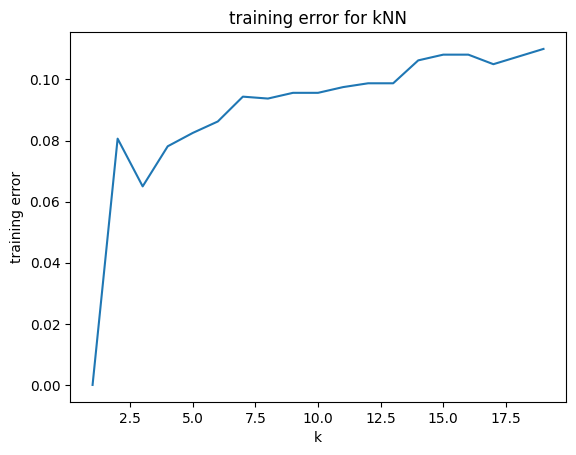

In [4]:
#from excercise 6.1 a)
np.random.seed(1)


misclassification = []

K = np.arange(1,20)
for k in K:
    model = skl_nb.KNeighborsClassifier(n_neighbors=k)
    model.fit(X_scaled, y)
    prediction = model.predict(X_scaled)
    misclassification.append(np.mean(prediction != y))

plt.plot(K, misclassification)
plt.title('training error for kNN')
plt.xlabel('k')
plt.ylabel('training error')

plt.show()
    

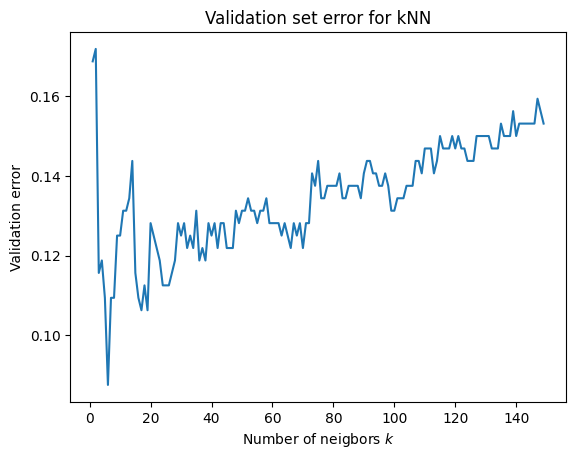

In [5]:
#from excercise 6.1 b)
np.random.seed(1)

N = len(X_scaled)
M = np.ceil(0.8*N).astype(int)

idx = np.random.permutation(N)
X_train, X_val = X_scaled.iloc[idx[:M]], X_scaled.iloc[idx[M:]]
y_train, y_val = y.iloc[idx[:M]],  y.iloc[idx[M:]]

misclassification = []

K = np.arange(1,150)
for k in K:
    model = skl_nb.KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    misclassification.append(np.mean(prediction != y_val))

plt.plot(K, misclassification)
plt.title('Validation set error for kNN')
plt.xlabel('Number of neigbors $k$')
plt.ylabel('Validation error')
plt.show()

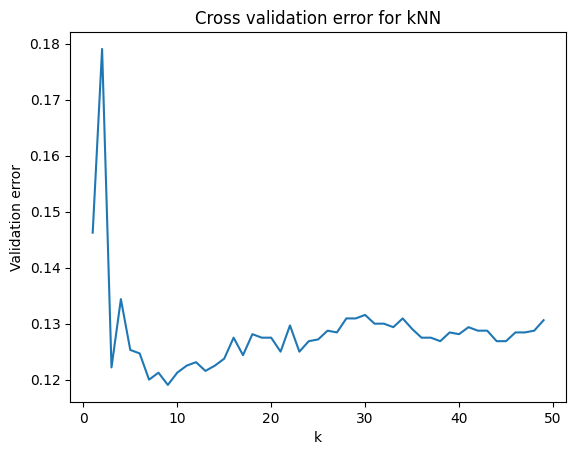

In [6]:
n_runs = 10
K = np.arange(1,50)

misclassification = np.zeros((n_runs, len(K)))
for i in range(n_runs):
    X_train, X_val, y_train, y_val = skl_ms.train_test_split(X_scaled, y, test_size=0.2)

    for j, k in enumerate(K):
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        misclassification[i, j] = (np.mean(prediction != y_val))

avarage_mis = np.mean(misclassification, axis=0)

plt.plot(K, avarage_mis)
plt.title('Cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('Validation error')
plt.show()

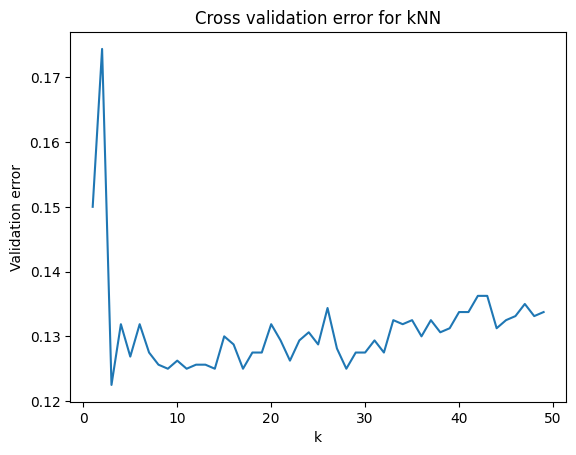

Average Succesrate for 2: 0.87750
Average Succesrate for 3: 0.86813
Average Succesrate for 4: 0.87313
Average Succesrate for 5: 0.86813
Average Succesrate for 6: 0.87250
Average Succesrate for 7: 0.87438


In [ ]:
n_fold = 10

cv = skl_ms.KFold(n_splits=n_fold, random_state=2,shuffle=True)
K = np.arange(1,50)
misclassification = np.zeros(len(K))

for train_index, val_index in cv.split(X_scaled):
    X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    for j, k in enumerate(K):
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        misclassification[j] += np.mean(prediction != y_val)

misclassification /= n_fold
plt.plot(K, misclassification)
plt.title('Cross validation error for kNN')
plt.xlabel('k')
plt.ylabel('Validation error')
plt.show()


for k_index in range (2,8):
    print(f"Average Succesrate for {k_index}: {1 - misclassification[k_index]:.5f}")

In [11]:
from sklearn.metrics import classification_report



X_train, X_val, y_train, y_val = skl_ms.train_test_split(X_scaled, y, test_size=0.2, random_state=1)

model = skl_nb.KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)
prediction = model.predict(X_val)

print(classification_report(y_val, prediction))

                  precision    recall  f1-score   support

high_bike_demand       0.49      0.66      0.56        50
 low_bike_demand       0.93      0.87      0.90       270

        accuracy                           0.84       320
       macro avg       0.71      0.77      0.73       320
    weighted avg       0.86      0.84      0.85       320



Average recall for k = 2: high demand: 0.54000 low demand: 0.92593
Average recall for k = 3: high demand: 0.66000 low demand: 0.87407
Average recall for k = 4: high demand: 0.54000 low demand: 0.92593
Average recall for k = 5: high demand: 0.64000 low demand: 0.90000
Average recall for k = 6: high demand: 0.52000 low demand: 0.93704


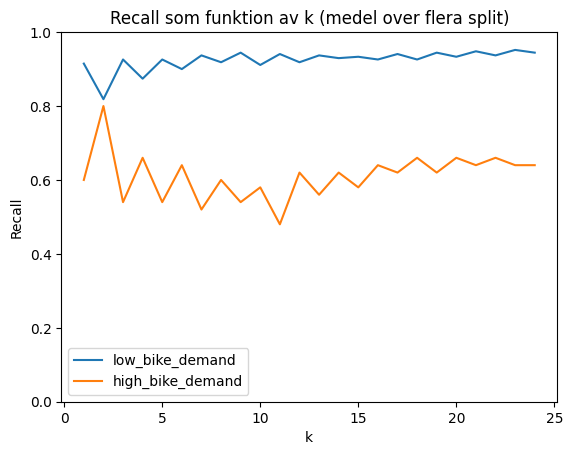

In [13]:
from sklearn.metrics import classification_report

K = np.arange(1, 25)
n_runs = 20
recall_low_runs = np.zeros((n_runs, len(K)))
recall_high_runs = np.zeros((n_runs, len(K)))

for run in range(n_runs):
    X_train, X_val, y_train, y_val = skl_ms.train_test_split(
        X_scaled, y, test_size=0.2, random_state=1
    )
    for j, k in enumerate(K):
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        report = classification_report(y_val, prediction, output_dict=True)
        recall_low_runs[run, j] = report["low_bike_demand"]["recall"]
        recall_high_runs[run, j] = report["high_bike_demand"]["recall"]

recall_low = np.mean(recall_low_runs, axis=0)
recall_high = np.mean(recall_high_runs, axis=0)

for k_index in range (2,7):
    print(f"Average recall for k = {k_index}: high demand: {recall_high[k_index]:.5f} low demand: {recall_low[k_index]:.5f}")


plt.plot(K, recall_low, label="low_bike_demand")
plt.plot(K, recall_high, label="high_bike_demand")
plt.title("Recall som funktion av k (medel over flera split)")
plt.xlabel("k")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.legend()
plt.show()